In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
# from pmdarima.arima import auto_arima
# from pmdarima.arima import ADFTest
from xgboost import XGBRegressor
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import optuna as ot

print(np.__version__)

2.1.1


In [1449]:
data = pd.read_csv('aggregated_data.csv')

# INFLATION ADJUSTMENT
base_cpi = data['CPI_US'].iloc[-1]
data['AVG_PRICE_AUCTION'] = data['AVG_PRICE_AUCTION'] * (base_cpi/data['CPI_US'])
data['CORN_FUTURES_TYPICAL_PRICE'] = data['CORN_FUTURES_TYPICAL_PRICE'] * (base_cpi/data['CPI_US'])
data['FEEDER_CATTLE_FUTURES_TYPICAL_PRICE'] = data['FEEDER_CATTLE_FUTURES_TYPICAL_PRICE'] * (base_cpi/data['CPI_US'])
data['US_MXN_RATES'] = data['US_MXN_RATES'] * (base_cpi/data['CPI_US'])
data['DIESEL_RETAIL_PRICE'] = data['DIESEL_RETAIL_PRICE'] * (base_cpi/data['CPI_US'])
data['DATE'] = pd.to_datetime(data['DATE'])

# ['avg_price_steers_ML1', 'avg_price_steers_ML1_2', 'avg_price_heifers_ML1', 'avg_price_heifers_ML1_2', 'CPI_US', 'NATIONAL_AUCTION_SALES','NATIONAL_TOTAL_SALES', 'TEXAS_AUCTION_SALES']
data = data.sort_values('DATE', ignore_index=True).set_index('DATE').drop(['avg_price_steers_ML1', 'avg_price_steers_ML1_2', 'avg_price_heifers_ML1', 'avg_price_heifers_ML1_2', 'NATIONAL_AUCTION_SALES','NATIONAL_TOTAL_SALES', 'TEXAS_AUCTION_SALES'], axis=1)
# print(data.head())


In [1450]:
def print_metrics(X_test, y_test, y_pred): # Helper function to print model metrics
    rf_r2 = r2_score(y_test, y_pred) # R²
    print(f'R² Score: {rf_r2}')

    # n = X_test.shape[0]
    # k = X_test.shape[1]
    # adj_r2 = 1-((1-rf_r2)*(n-1)/(n-k-1)) # Adjusted-R²
    # print(f'Adjusted-R² Score: {adj_r2}')

    prcorr = np.corrcoef(y_test, y_pred)[0,1] # Pearson Correlation Coefficient 
    print("Pearson correlation:", prcorr)

    srcorr, p_value = spearmanr(y_test, y_pred) # Spearman’s Rank Correlation
    print("Spearman correlation:", srcorr)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # RMSE
    print(f'Root Mean Squared Error (RMSE): {rmse}')

    mae = mean_absolute_error(y_test, y_pred) # MAE
    print(f'Mean Absolute Error (MAE): {mae}')

## RANDOM FOREST MODEL

In [1451]:
# # CREATE RANDOM FOREST MODEL
# X = data.drop(['AVG_PRICE_AUCTION'], axis=1)
# y = data['AVG_PRICE_AUCTION']

# # SPLIT DATA INTO 80/20 TRAINING TESTING SETS
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]
X_train = train_data.drop('AVG_PRICE_AUCTION', axis=1)
y_train = train_data['AVG_PRICE_AUCTION']
X_test = test_data.drop('AVG_PRICE_AUCTION', axis=1)
y_test = test_data['AVG_PRICE_AUCTION']

# CREATE AND TRAIN RF REGRESSOR
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# MAKE PREDICTIONS ON TEST SET
rf_pred = rf_regressor.predict(X_test)

# EVALUATING MODEL PERFORMANCE
print_metrics(X_test, y_test, rf_pred)

R² Score: -3.943770797294584
Pearson correlation: -0.5021780690567789
Spearman correlation: -0.2531698115427593
Root Mean Squared Error (RMSE): 32.846519439939755
Mean Absolute Error (MAE): 25.31080373094651


## XGBOOST MODEL

In [1452]:
# CREATE AND TRAIN XGBOOST REGRESSOR
xgb_reg = XGBRegressor()
xgb_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)

# EVALUATING MODEL PERFORMANCE
print_metrics(X_test, y_test, xgb_pred)

R² Score: -5.739373773327673
Pearson correlation: -0.4062557068643382
Spearman correlation: -0.23637696511493397
Root Mean Squared Error (RMSE): 38.350405861960006
Mean Absolute Error (MAE): 30.381297084927045


## LINEAR REGRESSION MODEL

In [1453]:
# CREATE AND TRAIN LINEAR REGRESSION MODEL
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
lrg_pred = lin_reg.predict(X_test)

# EVALUATING MODEL PERFORMANCE
print_metrics(X_test, y_test, lrg_pred)

R² Score: -1.0770318165124269
Pearson correlation: 0.6399813715256212
Spearman correlation: 0.6205553498704182
Root Mean Squared Error (RMSE): 21.29029932396304
Mean Absolute Error (MAE): 18.04539038941791


## ARIMA MODEL

In [ ]:
# freq = pd.infer_freq(data.index)
# print('Inferred frequency:', freq)

# FIND WHICH DATA POINTS ARE MISSING
start_date = data.index.min()
end_date = data.index.max()
full_index = pd.date_range(start=start_date, end=end_date, freq='W-FRI')
missing_dates = full_index.difference(data.index)
# print("Missing Dates:")
# print(missing_dates)

# REINDEX DATA & IMPUTE MISSING VALUES
# duplicates = data.index[data.index.duplicated()]
# print("Duplicate date entries:\n", duplicates)
arima_data = data.reindex(full_index).interpolate(method='linear')
price_series = arima_data['AVG_PRICE_AUCTION']

freq = pd.infer_freq(arima_data.index)
# print('Inferred frequency:', freq)

# PERFORM DIFFERENCING
# price_series_diff = price_series.diff().dropna()

# CHECK FOR STATIONARY WITH ADF TEST
adf_test = adfuller(price_series)
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

adf_test2 = ADFTest(alpha=0.05)
adf_test2.should_diff(price_series)

n = len(price_series)
train_size = int(n * 0.8)  # 80%

train = price_series.iloc[:train_size]
test = price_series.iloc[train_size:]


# # CREATE AND TRAIN ARIMA MODEL
# model = ARIMA(price_series, order=(1,1,1))
# model_fit = model.fit()
# # print(model_fit.summary())

# # FORECAST DATA
# forecast_length = len(test)
# test_forecast = model_fit.forecast(steps=forecast_length)
# test_forecast.index = test.index

# print_metrics(arima_data.index, test, test_forecast)

ADF Statistic: 0.619463142449429
p-value: 0.9880856655722295


NameError: name 'ADFTest' is not defined

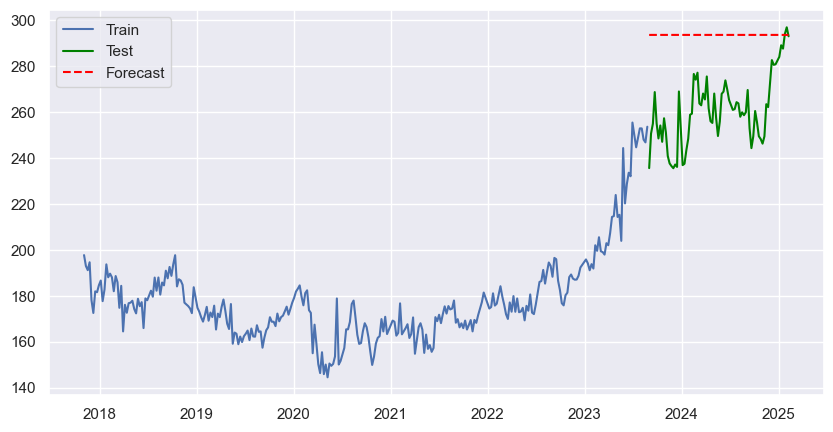

In [ ]:
# plt.figure(figsize=(10, 5))
# plt.plot(train.index, train, label='Train')
# plt.plot(test.index, test, label='Test', color='green')
# plt.plot(test_forecast.index, test_forecast, label='Forecast', color='red', linestyle='--')
# plt.legend()
# plt.show()

## DATA VISUALIZATION

In [ ]:
# VISUALIZATION OF DATA
fig = go.Figure()

# Historical (Training) data trace
fig.add_trace(go.Scatter(
    x=X_train.index, y=y_train,
    mode='lines+markers',
    name='Historical (Train)',
    line=dict(color='blue')
))

# Actual test data trace
fig.add_trace(go.Scatter(
    x=X_test.index, y=y_test,
    mode='lines+markers',
    name='Actual (Test)',
    line=dict(color='black')
))

# Forecast (Predicted) data trace
fig.add_trace(go.Scatter(
    x=X_test.index, y=lrg_pred,
    mode='lines+markers',
    name='Forecast (Predicted)',
    line=dict(color='red')
))

# Update layout with titles and axis labels
fig.update_layout(
    title='Model Fit: Historical Data and Forecast',
    xaxis_title='Date',
    yaxis_title='AVG_PRICE_AUCTION (Inflation Adjusted)',
    template='plotly_white'
)